## Part 1: Maximal Margin Classifier (Linear Seperable Case)
### Basic Concept

* Idea: Searches for a hyperplane by maximizing the seperation margin
* Explanation: First we can compute the prependicular distance from each training observations to a given seperating hyperplane, then the smallest such distance is the minimal distance from the observations to the hyperplane, known as margin
* Maximal margin hyperplane depends on only a small subset of the observations.

### Construct Maximal Margin Classifier


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import cvxopt
from scipy.optimize import minimize
from sklearn import svm, datasets

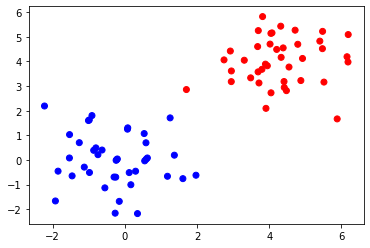

In [47]:
n=40
p=2
xpos=np.random.normal(0,1,n*p).reshape(n,p)
xneg=np.random.normal(4,1,n*p).reshape(n,p)
x=np.concatenate((xpos,xneg),axis=0)
y=np.concatenate((np.repeat(1,n),np.repeat(-1,n)),axis=0)

col = np.where(y>0,'b','r')
plt.scatter(x=x[:,0],y=x[:,1],c=col)
plt.show()

In [48]:
x1=xpos
x2=xneg*(-1)
x12=np.concatenate((x1,x2),axis=0)
ynew=y.reshape(1,80)

G=matrix(np.concatenate((ynew.T,x12),axis=1)*(-1),tc='d')
h=matrix(np.repeat(-1,n*2),tc='d')
p=matrix(np.diag([10**(-5),1+10**(-5),1+10**(-5)]), tc='d')
q=matrix(np.array([0,0,0]), tc='d')

sol = solvers.qp(p,q,G,h)
print(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  4.4679e-02  2.0029e+01  2e+02  2e+00  4e+02
 1:  2.9495e-01 -4.8307e+01  8e+01  7e-01  1e+02
 2:  6.9882e-01 -3.2194e+01  5e+01  4e-01  8e+01
 3:  1.3950e+00 -7.7891e+00  1e+01  5e-02  1e+01
 4:  1.3836e+00  1.0751e+00  3e-01  5e-04  9e-02
 5:  1.3116e+00  1.3061e+00  5e-03  7e-06  1e-03
 6:  1.3108e+00  1.3108e+00  6e-05  7e-08  1e-05
 7:  1.3108e+00  1.3108e+00  6e-07  7e-10  1e-07
 8:  1.3108e+00  1.3108e+00  6e-09  7e-12  1e-09
Optimal solution found.
[ 4.32e+00]
[-5.90e-01]
[-1.51e+00]



From the optimization result above, $\beta_0=4.32$, $\beta=[-5.9,-1.5]$
#### Plot the decision line, the two margin lines and the support vectors.

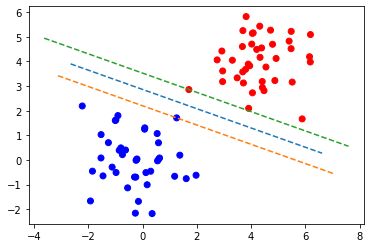

In [49]:
solution=sol['x']
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

plt.scatter(x=x[:,0],y=x[:,1],c=col)
abline(-solution[1]/solution[2],-solution[0]/solution[2])
abline(intercept=-(solution[0]-1)/solution[2],slope=-solution[1]/solution[2])
abline(intercept=-(solution[0]+1)/solution[2],slope=-solution[1]/solution[2])
plt.show()

## Part 2: Support Vector Classifier (Linear Non-Seperable Case)
### Basic Concept
Support Vector Classifier classifies a test observation depending on which siade of a hyperplane it lies. The hyperplane is chosen to correctly seperate most of the training observations but may misclassify a few observations.

### Construct Maximal Margin Classifier
Introduce "Slack variables" $\left\{\xi_i\right\}_{i=1}^n$ accounts for errors that allow individual observations to be on the wrong side of the margin or the hyperplane.
* $\xi_i=0$, ith observations is on the correct side of margin
* $\xi_i>0$, ith observations is on the wrong side of margin
* $\xi_i>1$, ith observations is on the wrong side of hyperplane

#### Primal Form
\begin{aligned}
\\ & minimize \frac{1}{2}\beta^T\beta+C\sum_{i=1}^n \xi_i
\\ s.t. & y_i(x_i^T\beta+\beta_0)\ge 1-\xi_i, i=1,2,...,n
\\ & \xi_i \ge 0, i=1,2,...,n\\
\end{aligned}
* Tuning Parameter C: Determines the number and severity of the violations to the margin(and hyperplane) that we will tolerate.
    + C=0: No budget for violations to the margin($\xi_1=\xi_2=...=\xi_n$)
    + C>0: No more than C observations can be on the wrong side of hyperplane  
As budget C increases, more tolerate of violations to the margin, so the margin will become wider.

#### Dual Form
\begin{aligned}
\\ & maximize \sum_{i=1}^n \alpha_i-\frac{1}{2}y_iy_j\alpha_i\alpha_jx_i^Tx_j
\\ s.t. & 0\leq\alpha_i \leq C, i=1,2,...,n
\\ & \sum_{i=1}^n \alpha_iy_i=0 \\
\end{aligned}

#### Example

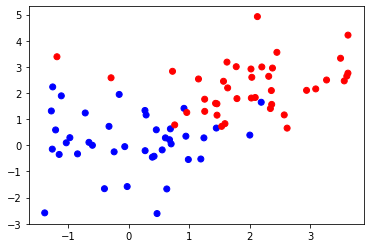

In [54]:
n=40
p=2
xpos=np.random.normal(0,1,n*p).reshape(n,p)
xneg=np.random.normal(2,1,n*p).reshape(n,p)
x=np.concatenate((xpos,xneg),axis=0)
y=np.concatenate((np.repeat(1,n),np.repeat(-1,n)),axis=0)

col = np.where(y>0,'b','r')
plt.scatter(x=x[:,0],y=x[:,1],c=col)
plt.show()

In [55]:
ynew=y.reshape(1,80)

A=matrix(ynew,tc='d')
b=matrix(np.array([0]),tc='d')

G1=np.diag(np.repeat(1,n*2))
G2=np.diag(np.repeat(-1,n*2))
G=matrix(np.concatenate((G1,G2),axis=0),tc='d')
h=matrix(np.concatenate((np.repeat(0.5,n*2),np.repeat(0,n*2)),axis=0),tc='d')

xx=np.dot(x,np.transpose(x))
yy=np.dot(np.transpose(ynew),ynew)
P=matrix(np.dot(xx,yy)+np.diag(np.repeat(10**(-5),2*n)),tc='d')
q=matrix(np.repeat(1,n*2),tc='d')

#sol = solvers.qp(p,q,G,h,A,b)
#print(sol['x'])

In [56]:
xx=np.dot(x,np.transpose(x))
yy=np.dot(np.transpose(ynew),ynew)
P=np.dot(xx,yy)+np.diag(np.repeat(10**(-5),2*n))

def f(x):
    return -np.dot(np.repeat(1,80),x)+1/2*np.dot(np.dot(np.transpose(x),P),x)

cons=({'type': 'ineq',
       'fun': lambda x: x},
      {'type': 'ineq',
       'fun': lambda x: -x+np.repeat(1,80)},
      {'type': 'eq',
       'fun': lambda x: np.dot(ynew,x)})

xxx=np.repeat(0.3,80)
result=minimize(f, x0=xxx, constraints=cons)
result

     fun: -79.99959999995198
     jac: array([-7208.71948242, -7208.71972656, -7208.71923828, -7208.71826172,
       -7208.71923828, -7208.71948242, -7208.71777344, -7208.71923828,
       -7208.71948242, -7208.71948242, -7208.71972656, -7208.71826172,
       -7208.71972656, -7208.71875   , -7208.71899414, -7208.71801758,
       -7208.71923828, -7208.71923828, -7208.71923828, -7208.71923828,
       -7208.71948242, -7208.71972656, -7208.71704102, -7208.71923828,
       -7208.71948242, -7208.71948242, -7208.71948242, -7208.71826172,
       -7208.71972656, -7208.71923828, -7208.71923828, -7208.71923828,
       -7208.71948242, -7208.71972656, -7208.71948242, -7208.71923828,
       -7208.71948242, -7208.71948242, -7208.71948242, -7208.71923828,
        7206.71899414,  7206.71875   ,  7206.71899414,  7206.71875   ,
        7206.71899414,  7206.71875   ,  7206.71875   ,  7206.71875   ,
        7206.71923828,  7206.71875   ,  7206.71875   ,  7206.71875   ,
        7206.71875   ,  7206.71875   ,

In [57]:
beta=np.dot(np.transpose(x),np.transpose(result.x*ynew))
beta0=-(max((np.dot(x,beta))[40:80])+ min((np.dot(x,beta))[0:40]))/2
[beta0,beta]

[array([215.65857513]), array([[-77.02850763],
        [-84.2925604 ]])]

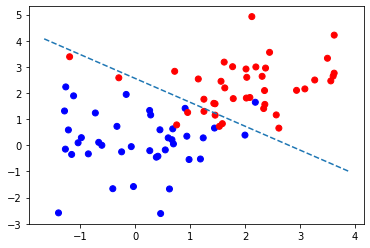

In [58]:
plt.scatter(x=x[:,0],y=x[:,1],c=col)
abline(-beta[0]/beta[1],-beta0/beta[1])
plt.show()

In [59]:
clf = svm.SVC(kernel='linear', C = 1.0)
clf.fit(x,y)
print(clf.coef_[0])
print(clf.intercept_)

[-1.07097769 -1.41200772]
[2.7290047]


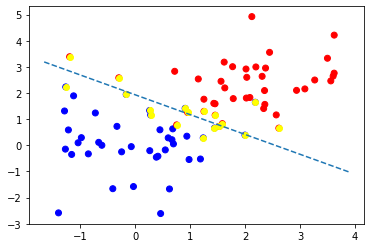

In [64]:
beta=clf.coef_[0]
beta0=clf.intercept_
sv=clf.support_vectors_ # support vectors
plt.scatter(x=x[:,0],y=x[:,1],c=col)
abline(-beta[0]/beta[1],-beta0/beta[1])
plt.scatter(x=sv[:,0],y=sv[:,1], c='yellow')
plt.show()

I marked the support vectors with yellow points.

## Part 3: Support Vector Machine (Non-Linear Case)
### Basic Concept
In many cases, linear classifier is not flexible enough. Support Vector Machine Classifier is an extension of support vector classifier, where the dimension of the enlarged space is allowed to get very large.
* Enlarge the feature space via basis expansions: $\Phi: \chi\to F$, $\Phi(x)=\phi_1(x),\phi_2(x),...$
* The decision function becomes: $f(x)=\left \langle \Phi(x),\beta \right \rangle$

### Construct Maximal Margin Classifier  
\begin{aligned}
\\ & maximize \sum_{i=1}^n \alpha_i-\frac{1}{2}y_iy_j\alpha_i\alpha_j\left \langle \Phi(x_i),\Phi(x_j) \right \rangle
\\ s.t. & 0\leq\alpha_i \leq C, i=1,2,...,n
\\ & \sum_{i=1}^n \alpha_iy_i=0 \\
\end{aligned}

* Kernel trick saves computation time!
    + Calculating $\left \langle \Phi(x_i),\Phi(x_j) \right \rangle$ requires $p^2$ products when calculating the inner products, so the computation time is $O(p^2)$, where $p$ is the length of $x$.
    - Calculating kernel distance requires doing p products and square sum. So the computation time is $O(p)$.
    
#### Example
I will use SVM classifiers with different kernels in the iris dataset.
Comparison of different linear SVM classifiers on a 2D projection(in order to better visualization) of the iris dataset. Only consider the first 2 features of this dataset: Sepal length and Sepal width.

In [69]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target
h = .02

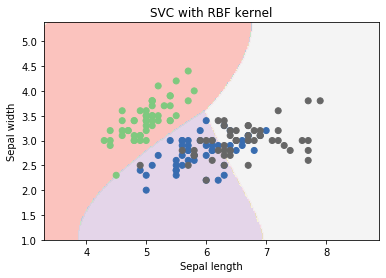

In [89]:
rbf_svc = svm.SVC(kernel='rbf', gamma='auto', C=1).fit(X,y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=1, gamma='auto').fit(X, y)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = rbf_svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap="Pastel1", alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Accent")
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title("SVC with RBF kernel")
plt.show()

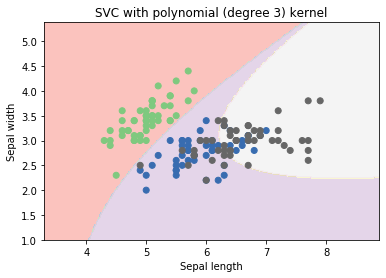

In [90]:
Z = poly_svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap="Pastel1", alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Accent")
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title("SVC with polynomial (degree 3) kernel")
plt.show()